## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.unique().shape[0]

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + df.query('group == "control" and landing_page != "old_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isna().sum().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2_1 = df.query('group == "treatment" and landing_page == "new_page"')
df2_2 = df.query('group == "control" and landing_page == "old_page"')

df2 = df2_1.append(df2_2)
df2.shape[0]


290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].unique().shape[0]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# User ID is 773192
df2['user_id'].loc[df2['user_id'].duplicated()].values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset ="user_id", inplace = True)
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.query('converted == 1').shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
P_cont_grp = df2.query('converted == 1 and group == "control"').shape[0] / df2.query('group == "control"').shape[0]
P_cont_grp

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
P_treat_grp = df2.query('converted == 1 and group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
P_treat_grp

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.


### No it's not sufficient

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null Hypothesis                      $H_{0}$ :  $p_{new}$ - $p_{old}$ <= 0.05   
#### Alternative Hypothesis          $H_{1}$ :  $p_{new}$ - $p_{old}$ > 0.05

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

#### Null Hypothesis                      $H_{0}$ :  $p_{new}$ - $p_{old}$ <= 0    (New Page is like or worse than old Page)
#### Alternative Hypothesis          $H_{1}$ :  $p_{new}$ - $p_{old}$ > 0 (New Page is better than old Page)

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# Get the mean of Converted
P_new = df2.query('converted == 1').shape[0] / df2.shape[0]
P_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
# Get the mean of Converted
P_old = df2.query('converted == 1').shape[0] / df2.shape[0]
P_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
# counting the treatment
N_new = df2.query('group == "treatment"').shape[0]
N_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
# counting the Control
N_old = df2.query('group == "control"').shape[0]
N_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# Simulation with replacement using Random Choice function
new_page_converted = np.random.choice([0,1],size=N_new,p=[(1-P_new),P_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1],size=N_old,p=[(1-P_old),P_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# Get the differences
P_diff = new_page_converted.mean() - old_page_converted.mean()
P_diff

0.001794197998303243

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#Create empty dataset to put the differences
p_diffs = []

#Do 10000 Iteration simulation Process & append results of differences for each time into dataframe
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size=N_new,p=[(1-P_new),P_new])
    old_page_converted = np.random.choice([0,1],size=N_old,p=[(1-P_old),P_old])
    P_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(P_diff)
    
# put the final results into array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  2.00000000e+00,   5.10000000e+01,   3.93000000e+02,
          1.64900000e+03,   3.12800000e+03,   2.99300000e+03,
          1.43800000e+03,   3.08000000e+02,   3.50000000e+01,
          3.00000000e+00]),
 array([ -5.10940848e-03,  -4.07284751e-03,  -3.03628654e-03,
         -1.99972557e-03,  -9.63164605e-04,   7.33963644e-05,
          1.10995733e-03,   2.14651830e-03,   3.18307927e-03,
          4.21964024e-03,   5.25620121e-03]),
 <a list of 10 Patch objects>)

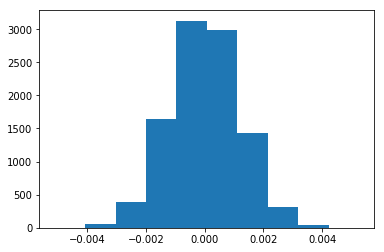

In [27]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# First we need to calculate the Actual Differences

Actual_diffs = P_treat_grp - P_cont_grp
Actual_diffs

-0.0015782389853555567

In [29]:
p_diff_std = p_diffs.std()
p_diff_std

0.0011938161999300641

(array([   25.,   150.,   571.,  1530.,  2520.,  2540.,  1739.,   725.,
          174.,    26.]),
 array([ -4.18262931e-03,  -3.36141627e-03,  -2.54020323e-03,
         -1.71899019e-03,  -8.97777154e-04,  -7.65641142e-05,
          7.44648926e-04,   1.56586197e-03,   2.38707501e-03,
          3.20828805e-03,   4.02950109e-03]),
 <a list of 10 Patch objects>)

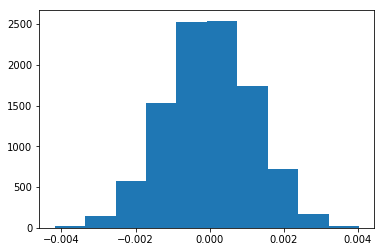

In [30]:
null_vals = np.random.normal(0,p_diff_std,p_diffs.size)
plt.hist(null_vals)

In [31]:
# Calculate the Proportion of null_vals > Actual_diffs (P-Value)
(null_vals>Actual_diffs).mean()

0.90859999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### P-Value , And the Result explain that New Page is better than old Page

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_inv_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='larger')
#z_score
p_value = 1- p_inv_value
p_value


0.90505831275902449

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### The output Result is very near between Part j and m for the p-value , However there's some slight differences

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### Linear regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [35]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])

In [36]:
df2.drop('control',axis='columns', inplace=True)

In [37]:
df2.rename(columns = { 'treatment': 'ab_page'}, inplace = True)

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
mod = sm.OLS(df2['converted'], df2[['intercept','ab_page']])
res = mod.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Mon, 17 May 2021   Prob (F-statistic):              0.190
Time:                        18:09:46   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.0

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### P-Value = 0.975 , There is differences between Part 3 and Part 2 , In Part 2 we consider only the column converted into the equation however In Part 3 we add the group column into hypotheses equation

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### Yes it's better to add more variables to regression model , Adding more terms to the multiple regression inherently improves the fit. It gives a new term for the model to use to fit the data, and a new coefficient that it can vary to force a better fit. ... Adding more and more variables makes it more and more likely that you will overfit your model to the training data

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
df_cont = pd.read_csv('countries.csv')
df_cont.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
# Join the 2 dataframes by  user_id
df_full = df_cont.join(df2.set_index('user_id'), on='user_id')
df_full.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
# Create the 2 columns for the 3 dummies variables of country
df_full[['CA','UK','US']] = pd.get_dummies(df_full['country'])
df_full.drop('US',
  axis='columns', inplace=True)
df_full.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
mod = sm.OLS(df_full['converted'], df_full[['intercept','ab_page','CA','UK']])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Mon, 17 May 2021   Prob (F-statistic):              0.178
Time:                        18:09:47   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1203      0.001    128.267      0.0

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0